In [129]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l1, l2
from keras.optimizers import Nadam, Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [130]:
x = np.load('data/EEG_all_epochs.npy')
y = np.load('data/EEG_contaminated_with_EOG/EEG_contaminated_with_EOG_2db.npy')

print(x.shape)
print(y.shape)

(4514, 512)
(4514, 512)


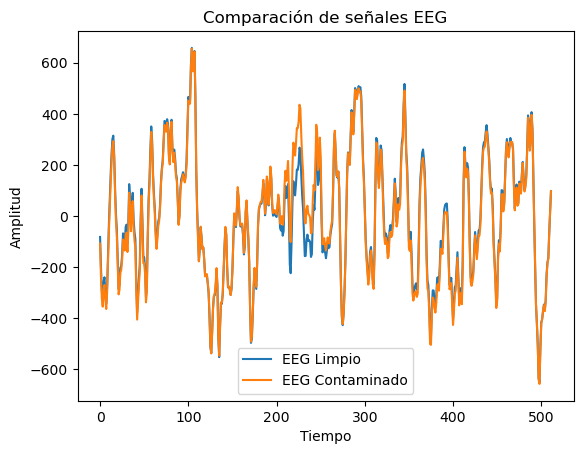

In [131]:
# Escoge una muestra al azar
index = np.random.randint(0, x.shape[0])

# Crea una figura y los ejes para el subplot
fig, ax = plt.subplots()

# Grafica la señal limpia y contaminada en la misma gráfica
ax.plot(x[index, :], label='EEG Limpio')
ax.plot(y[index, :], label='EEG Contaminado')

# Configura el título y las etiquetas de los ejes
ax.set_title('Comparación de señales EEG')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Amplitud')

# Muestra la leyenda
ax.legend()

plt.show()


# Preprocesamiento de los datos en preparacion para la LSTM

In [132]:
# Tamaño de set de prueba
test_size = 0.2

# Calcula el índice donde se hará la división
split_idx = int(len(x) * (1-test_size))

# Divide los datos en conjuntos de entrenamiento y prueba
x_train = x[:split_idx]
y_train = y[:split_idx]
x_test = x[split_idx:]
y_test = y[split_idx:]

In [133]:
# Normalización de los datos
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
y_train_norm = scaler.transform(y_train)
x_test_norm = scaler.transform(x_test)
y_test_norm = scaler.transform(y_test)

# Reshape de los datos
timesteps = 100
n_samples, n_features = x_train_norm.shape
n_sequences = n_samples // timesteps
x_train_reshaped = np.reshape(x_train_norm[:n_sequences * timesteps, :], (n_sequences, timesteps, n_features))

n_samples, n_features = y_train_norm.shape
n_sequences = n_samples // timesteps
y_train_reshaped = np.reshape(y_train_norm[:n_sequences * timesteps, :], (n_sequences, timesteps, n_features))

n_samples, n_features = x_test_norm.shape
n_sequences = n_samples // timesteps
x_test_reshaped = np.reshape(x_test_norm[:n_sequences * timesteps, :], (n_sequences, timesteps, n_features))

n_samples, n_features = y_test_norm.shape
n_sequences = n_samples // timesteps
y_test_reshaped = np.reshape(y_test_norm[:n_sequences * timesteps, :], (n_sequences, timesteps, n_features))

print(x_train_reshaped.shape)
print(y_train_reshaped.shape)
print(x_test_reshaped.shape)
print(y_test_reshaped.shape)


(36, 100, 512)
(36, 100, 512)
(9, 100, 512)
(9, 100, 512)


In [134]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(3611, 512)
(903, 512)
(3611, 512)
(903, 512)


In [135]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, n_features)))  
model.add(Dropout(0.3))  # Ajuste de la tasa de Dropout
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True)) # Capa adicional
model.add(Dense(32, activation='relu', activity_regularizer=l2(0.001)))  
model.add(Dense(n_features, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=Adam())


In [136]:
# Entrenar el modelo
history = model.fit(x_train_reshaped, y_train_reshaped, epochs=100, batch_size=128, 
                    validation_data=(x_test_reshaped, y_test_reshaped))

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 1.5571 - val_loss: 1.5342
Epoch 2/100
1/1 [==============================] - 0s 208ms/step - loss: 1.5432 - val_loss: 1.5295
Epoch 3/100
1/1 [==============================] - 0s 213ms/step - loss: 1.5383 - val_loss: 1.5264
Epoch 4/100
1/1 [==============================] - 0s 209ms/step - loss: 1.5358 - val_loss: 1.5240
Epoch 5/100
1/1 [==============================] - 0s 212ms/step - loss: 1.5343 - val_loss: 1.5223
Epoch 6/100
1/1 [==============================] - 0s 219ms/step - loss: 1.5335 - val_loss: 1.5211
Epoch 7/100
1/1 [==============================] - 0s 217ms/step - loss: 1.5328 - val_loss: 1.5203
Epoch 8/100
1/1 [==============================] - 0s 226ms/step - loss: 1.5326 - val_loss: 1.5197
Epoch 9/100
1/1 [==============================] - 0s 218ms/step - loss: 1.5324 - val_loss: 1.5192
Epoch 10/100
1/1 [==============================] - 0s 220ms/step - loss: 1.5323 - val_loss: 1.5189
Epoch 11/100

In [137]:
# Crear listas para almacenar los resultados de cada métrica
mse_values = []
rmse_values = []
mae_values = []
corr_values = []

# Primero, genera algunas predicciones a partir de tus datos de prueba
y_pred = model.predict(y_test_reshaped)

# Bucle sobre cada señal en los datos de prueba
for signal_number in range(y_test_reshaped.shape[0]):

    # Obtén la señal limpia real y la señal limpia predicha para esta señal específica
    real_clean_signal = x_test_reshaped[signal_number]
    predicted_clean_signal = y_pred[signal_number]

    # Invierte la normalización de los datos
    real_clean_signal_inv = scaler.inverse_transform(real_clean_signal)
    predicted_clean_signal_inv = scaler.inverse_transform(predicted_clean_signal)

    # Selecciona un solo registro EEG
    real_clean_signal_single = real_clean_signal_inv[0, :] # Primer registro
    predicted_clean_signal_single = predicted_clean_signal_inv[0, :] # Primer registro

    # Calcular MSE
    mse = mean_squared_error(real_clean_signal_single, predicted_clean_signal_single)
    mse_values.append(mse)

    # Calcular RMSE
    rmse = np.sqrt(mse)
    rmse_values.append(rmse)

    # Calcular MAE
    mae = mean_absolute_error(real_clean_signal_single, predicted_clean_signal_single)
    mae_values.append(mae)

    # Calcular Correlación de Pearson
    corr, _ = pearsonr(real_clean_signal_single, predicted_clean_signal_single)
    corr_values.append(corr)

# Calcular la media de cada métrica
mse_mean = np.mean(mse_values)
rmse_mean = np.mean(rmse_values)
mae_mean = np.mean(mae_values)
corr_mean = np.mean(corr_values)

print("Mean MSE:", mse_mean)
print("Mean RMSE:", rmse_mean)
print("Mean MAE:", mae_mean)
print("Mean Pearson's correlation:", corr_mean)

"""
# Grafica los datos
plt.figure(figsize=(12, 6))
plt.plot(real_clean_signal_single, label='Real clean signal')
plt.plot(predicted_clean_signal_single, label='Predicted clean signal')
plt.legend()
plt.title('Comparison of real and predicted clean signals')
plt.show()
"""

1/1 [==============================] - 1s 1s/step
Mean MSE: 39992.635516920694
Mean RMSE: 196.99305420678215
Mean MAE: 156.60316881786488
Mean Pearson's correlation: 0.060214174018848085


"\n# Grafica los datos\nplt.figure(figsize=(12, 6))\nplt.plot(real_clean_signal_single, label='Real clean signal')\nplt.plot(predicted_clean_signal_single, label='Predicted clean signal')\nplt.legend()\nplt.title('Comparison of real and predicted clean signals')\nplt.show()\n"